<h1 style="text-align: center;">Transformer model for stock predicition</h1>

### Parameters

In [10]:
days_for_prediction = 14


### Import of libraries

In [11]:
import pandas as pd;
import os;
import keras;
import numpy as np;
import matplotlib.pyplot as plt;
import tensorflow as tf

### Functions for loading of preprocessed data

In [12]:
def import_data_from_csv(path: str):
    """
    Imports data from a csv file and returns a pandas dataframe.
    """
    return pd.read_csv(path)


### Functions for preparing data for Transformer model

In [13]:
def split_data_into_training_and_test_sets(df: pd.DataFrame, window_start: int, window_end: int, test_size: float) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits data into training and test sets.
    """
    data_count = window_end - window_start
    test_data_count = int(data_count * test_size)

    end_of_training_data = window_start + test_data_count

    return df.iloc[window_start : end_of_training_data], df.iloc[end_of_training_data : window_end]

def extract_features_required_for_training(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    """
    Extracts features required for training.
    """
    return df[features]

def reshape_data_for_transformer(df: pd.DataFrame, window_size: int, number_of_atributes: int) -> np.ndarray:
    """
    Reshapes data for transformer.
    """
    data = df.to_numpy()
    samples = int(data.shape[0] / window_size)
    array_splits = np.arange(window_size, data.shape[0], window_size)
    splited = np.split(data, array_splits)

    if(splited[-1].shape[0] != window_size):
        splited = splited[:-1]

    result = np.array(splited)
    return result.reshape((samples, window_size, number_of_atributes))

def final_preparation_of_data(initial_data: np.ndarray, window_size: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Final preparation of data.
    """
    data = initial_data.reshape((initial_data.shape[0]*initial_data.shape[1], initial_data.shape[2]))
    x, y = [], []
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + window_size
        out_end = in_end + window_size
        if out_end <= len(data):
            x.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, :])
        in_start += 1

    return np.array(x), np.array(y)


### Positional Encoding

In [14]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

### Functions for building Transformer model

In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout : float =0, attention_axes=None):
  """
  Creates a single transformer block.
  """
  x = keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = keras.layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = keras.layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = keras.layers.LayerNormalization(epsilon=1e-6)(res)
  x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = keras.layers.Dropout(dropout)(x)
  x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout : float =0, 
                      mlp_dropout : float =0, 
                      attention_axes=None) -> keras.Model:
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = days_for_prediction, 1, days_for_prediction 
  inputs = keras.Input(shape=(n_timesteps, n_features))

  # Add positional encoding layer
  pos_encoding = positional_encoding(n_timesteps, n_features)
  x = inputs + pos_encoding
  
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, attention_axes)
  
  x = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = keras.layers.Dense(dim, activation="relu")(x)
    x = keras.layers.Dropout(mlp_dropout)(x)

  outputs = keras.layers.Dense(n_outputs, activation='relu')(x)
  return keras.Model(inputs, outputs)

### Functions for predicting of values

In [16]:
def forecast(history : list, model : keras.Model, window_size : int):
    """
    Given last weeks actual data, forecasts next weeks prices.
    """
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-window_size:, :]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose="0")
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

def get_predictions(model : keras.Model, x_values : np.ndarray, window_size : int):
    history = [x for x in x_values]
    predictions = list()

    for i in range(len(x_values)):
        yhat_sequence = forecast(history, model, window_size)
        predictions.append(yhat_sequence)
        history.append(x_values[i, :])

    return np.array(predictions)

def plot_results(test, preds, df, title_suffix=None, xlabel='AAPL stock Price'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  # x = df.Close[-498:].index
  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(plot_test, label='actual')
  ax.plot(plot_preds, label='preds')
  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')
  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  plt.show()

### Main Implementation

Epoch 1/50
128/128 [==============================] - 42s 161ms/step - loss: 0.0044 - mae: 0.0548 - mape: 61.9048 - val_loss: 0.0022 - val_mae: 0.0423 - val_mape: 28.6691
Epoch 2/50
128/128 [==============================] - 21s 164ms/step - loss: 0.0027 - mae: 0.0423 - mape: 48.8493 - val_loss: 0.0018 - val_mae: 0.0383 - val_mape: 26.0814
Epoch 3/50
128/128 [==============================] - 19s 148ms/step - loss: 0.0019 - mae: 0.0346 - mape: 40.2812 - val_loss: 0.0011 - val_mae: 0.0301 - val_mape: 20.3238
Epoch 4/50
128/128 [==============================] - 19s 148ms/step - loss: 0.0013 - mae: 0.0283 - mape: 32.8213 - val_loss: 6.7187e-04 - val_mae: 0.0223 - val_mape: 14.8755
Epoch 5/50
128/128 [==============================] - 19s 149ms/step - loss: 8.0738e-04 - mae: 0.0226 - mape: 26.2287 - val_loss: 6.3096e-04 - val_mae: 0.0223 - val_mape: 15.0213
Epoch 6/50
128/128 [==============================] - 19s 151ms/step - loss: 5.4804e-04 - mae: 0.0186 - mape: 21.4807 - val_loss: 3.3

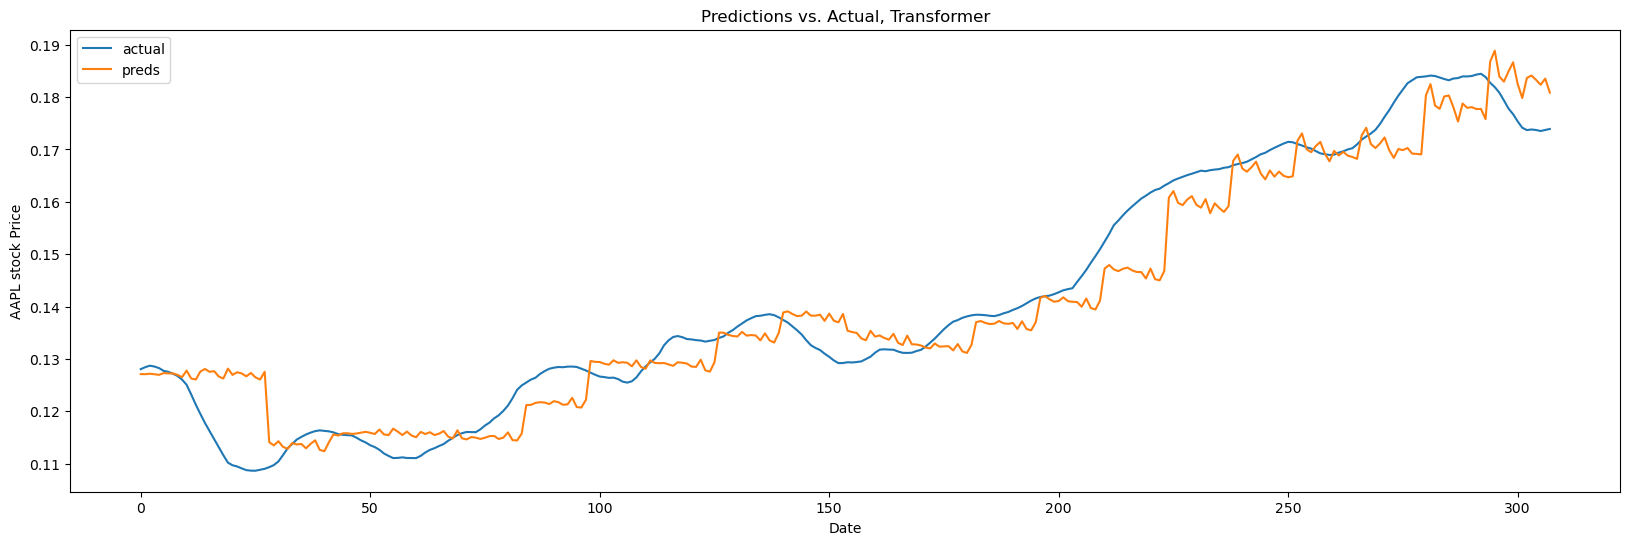

In [20]:
loaded_data = import_data_from_csv("../../data/processed/AAPL.csv")
extracted_data = extract_features_required_for_training(loaded_data, ["Adj Close"])

training_data, test_data = split_data_into_training_and_test_sets(extracted_data, 0, int(extracted_data.shape[0] * 0.5), 0.8)
reshaped_training_data = reshape_data_for_transformer(training_data, days_for_prediction, 1)
reshaped_test_data = reshape_data_for_transformer(test_data, days_for_prediction, 1)
training_x_values, training_y_values = final_preparation_of_data(reshaped_training_data, days_for_prediction)
validation_x_values, validation_y_values = final_preparation_of_data(reshaped_test_data, days_for_prediction)

transformer = build_transfromer(head_size=256, num_heads=14, ff_dim=4, 
                                num_trans_blocks=8, mlp_units=[512], 
                                mlp_dropout=0.15, dropout=0.15)

transformer.compile(
    loss="mae",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae", 'mape'],
)

#transformer.summary()

if(os.path.exists("checkpoints/transformer.keras")):
    transformer = keras.models.load_model("checkpoints/transformer.keras")
else:
    callbacks = [keras.callbacks.EarlyStopping(patience=10, 
                                        restore_best_weights=True)]

    t_hist = transformer.fit(training_x_values, training_y_values, batch_size=10,
                        epochs=50, validation_data=(validation_x_values, validation_y_values), callbacks=callbacks, shuffle=True)
    
    transformer.save("checkpoints/transformer.keras")

                        

#visualize_history(t_hist)

predictions = get_predictions(transformer, reshaped_test_data, days_for_prediction)

plot_results(reshaped_test_data, predictions, test_data, title_suffix='Transformer')